In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

/Users/namanbajpai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=15
EPOCHS=50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


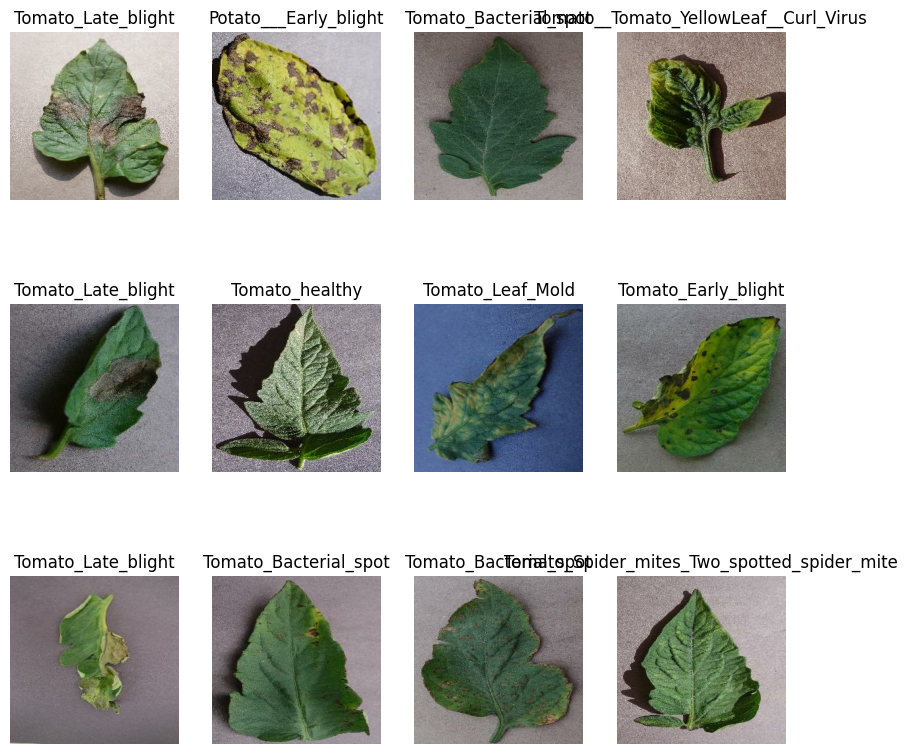

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

645

In [11]:
train_size = 0.8
len(dataset)*train_size

516.0

In [12]:
train_ds = dataset.take(516)
len(train_ds)

516

In [13]:
test_ds = dataset.skip(516)
len(test_ds)

129

In [14]:
val_size=0.1
len(dataset)*val_size

64.5

In [15]:
val_ds = test_ds.take(64)
len(val_ds)

64

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

123

In [17]:
 def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)


516

In [20]:
len(val_ds)

64

In [21]:
len(test_ds)

65

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, None)    0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
516/516 [==============================] - ETA: 0s - loss: 2.1151 - accuracy: 0.3161

2024-02-06 22:24:12.132107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 347 of 10000
2024-02-06 22:24:22.136654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 414 of 10000
2024-02-06 22:24:32.356827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 495 of 10000
2024-02-06 22:24:52.197072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 617 of 10000
2024-02-06 22:24:56.582393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-06 22:24:57.211955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


516/516 [==============================] - 1027s 2s/step - loss: 2.1151 - accuracy: 0.3161 - val_loss: 1.5955 - val_accuracy: 0.4824
Epoch 2/50
516/516 [==============================] - 802s 2s/step - loss: 1.3576 - accuracy: 0.5559 - val_loss: 1.0211 - val_accuracy: 0.6646
Epoch 3/50
516/516 [==============================] - 750s 1s/step - loss: 0.8639 - accuracy: 0.7059 - val_loss: 1.0370 - val_accuracy: 0.6587
Epoch 4/50
516/516 [==============================] - 849s 2s/step - loss: 0.6459 - accuracy: 0.7803 - val_loss: 0.7233 - val_accuracy: 0.7490
Epoch 5/50
516/516 [==============================] - 815s 2s/step - loss: 0.5120 - accuracy: 0.8212 - val_loss: 0.5435 - val_accuracy: 0.8130
Epoch 6/50
516/516 [==============================] - 825s 2s/step - loss: 0.4339 - accuracy: 0.8527 - val_loss: 0.3975 - val_accuracy: 0.8618
Epoch 7/50
516/516 [==============================] - 1700s 3s/step - loss: 0.3914 - accuracy: 0.8622 - val_loss: 0.5768 - val_accuracy: 0.7983
Epoch 8/

In [38]:
scores = model.evaluate(test_ds)

2024-02-07 14:49:15.174498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 331 of 10000
2024-02-07 14:49:32.472525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 483 of 10000
2024-02-07 14:49:43.439513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 546 of 10000
2024-02-07 14:49:54.102346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-02-07 14:49:54.789042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:28: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-02-07 14:49:54.796652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


65/65 [==============================] - 86s 498ms/step - loss: 0.1127 - accuracy: 0.9654


In [39]:
scores

[0.11271325498819351, 0.9653846025466919]

In [40]:
history

In [42]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 516}

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
 type(history.history['loss'])

list

In [45]:
 len(history.history['loss'])

50

In [46]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.1150565147399902,
 1.357606053352356,
 0.8638588786125183,
 0.6458544135093689,
 0.5120310187339783]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

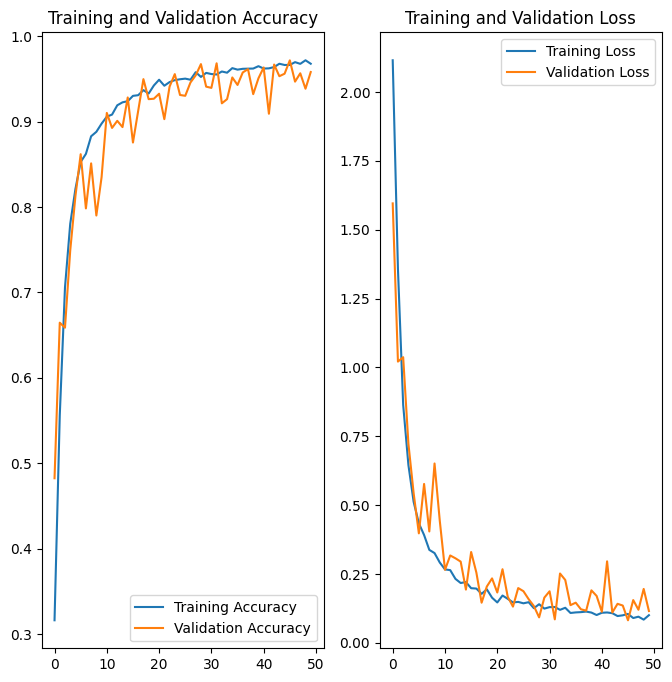

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Early_blight
1/1 [==============================] - 0s 417ms/step
predicted label: Tomato_Early_blight


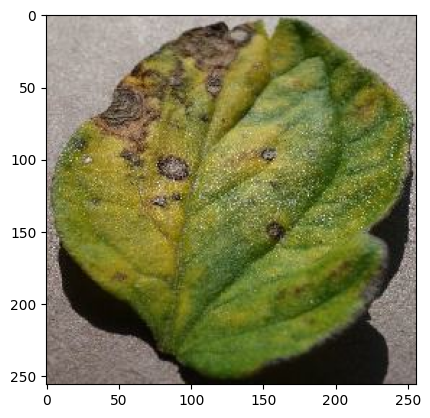

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
 def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


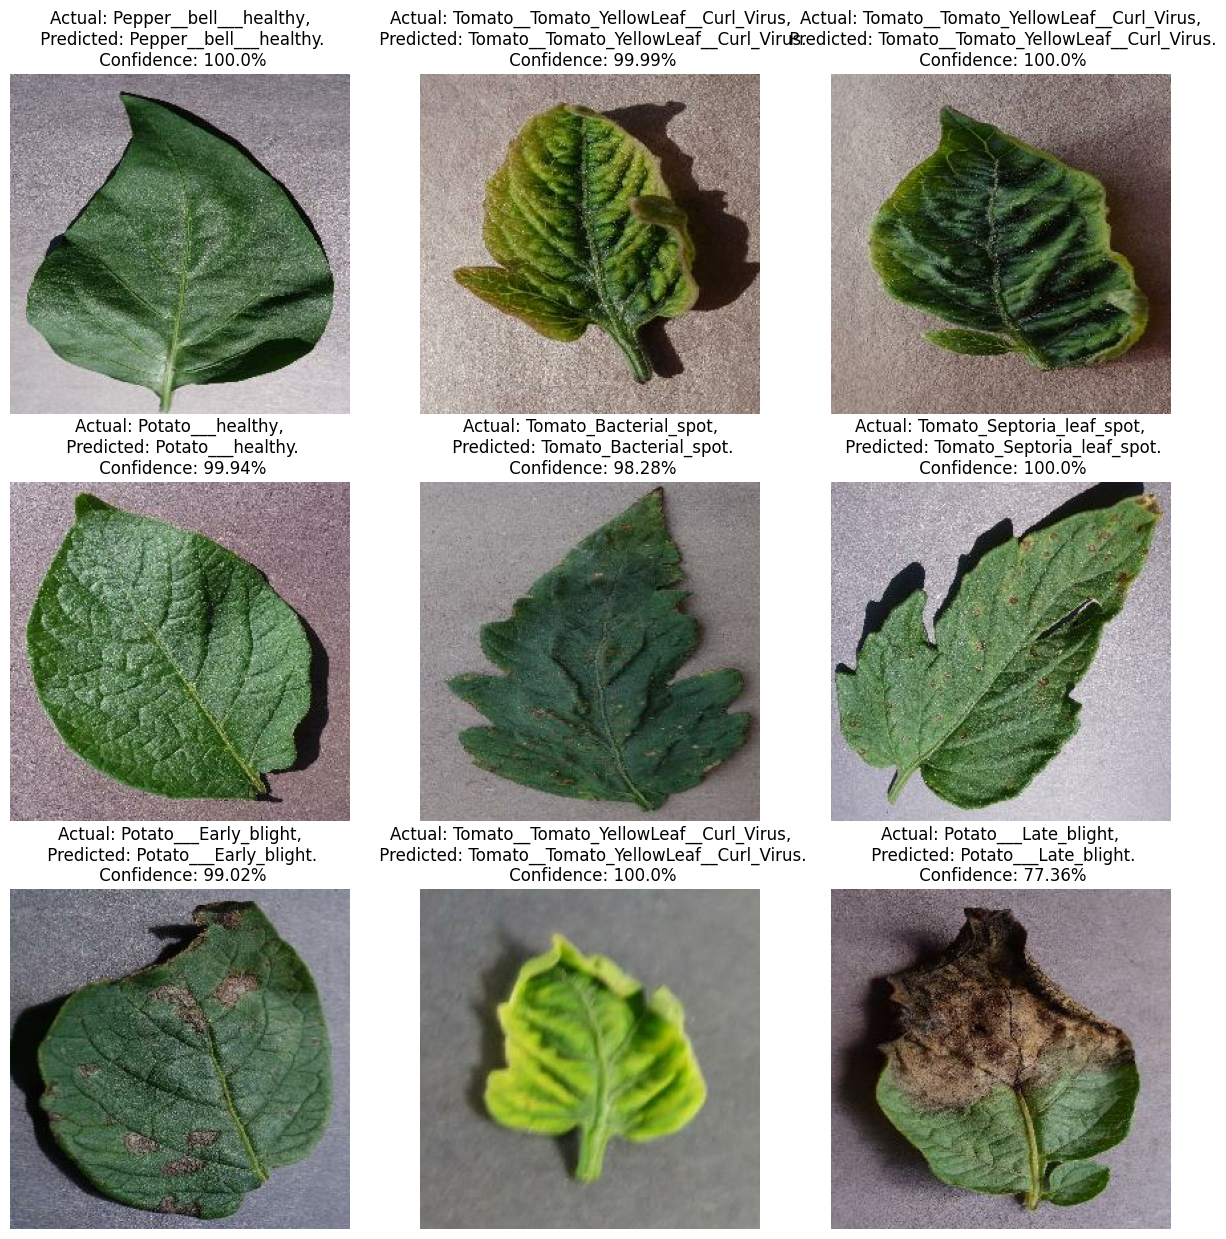

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
import os

# Define the base directory where you want to save the model
base_dir = "/Users/namanbajpai/Desktop/CI102/restart"

# Check if the directory exists, if not, create it
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Get the next version number for the model
model_version = max([int(i) for i in os.listdir(base_dir) if i.isdigit()] + [0]) + 1

# Save the model in the specified directory with the version number
model.save(f"{base_dir}/model_{model_version}")

INFO:tensorflow:Assets written to: /Users/namanbajpai/Desktop/CI102/restart/model_1/assets


INFO:tensorflow:Assets written to: /Users/namanbajpai/Desktop/CI102/restart/model_1/assets


In [53]:
model.save("../plantdoc1.h5")

/Users/namanbajpai/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
